# =============================================================
# MILESTONE 3: Machine Learning Model Development and Optimization
# =============================================================

In [ ]:
%pip install xgboost

In [2]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                      StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV


In [3]:
url = "../data/processed/processed_data.csv"
df = pd.read_csv(url)

df.shape

(3333, 16)

In [4]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train/test split (80/20) with stratification

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:", np.bincount(y_train))

Before SMOTE: [2280  386]



# Apply SMOTE only to training set

In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_resampled))

After SMOTE: [2280 2280]


# =============================================================
#  MODEL SELECTION AND INITIALIZATION
# =============================================================

In [7]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

print(f"\nModels initialized: {list(models.keys())}")


Models initialized: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']


# =============================================================
# TRAINING MODELS ON FULL TRAINING SET
# =============================================================

In [8]:
print("\n" + "="*70)
print("TRAINING MODELS ON FULL TRAINING SET")
print("="*70)

trained_models = {}
train_predictions = {}
test_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model
    
    # Training set predictions (for overfitting detection)
    y_train_pred = model.predict(X_train_resampled)
    y_train_prob = model.predict_proba(X_train_resampled)[:, 1]
    
    train_predictions[name] = {
        'y_pred': y_train_pred,
        'y_prob': y_train_prob
    }
    
    # Test set predictions
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    test_predictions[name] = {
        'y_pred': y_test_pred,
        'y_prob': y_test_prob
    }


TRAINING MODELS ON FULL TRAINING SET

Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...


d:\Users\LENOVO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:17:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# =============================================================
# MODEL EVALUATION ON TEST SET
# =============================================================

In [9]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

test_results = []

for name in models.keys():
    y_pred = test_predictions[name]['y_pred']
    y_prob = test_predictions[name]['y_prob']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    test_results.append({
        'Model': name,
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_ROC_AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

test_results_df = pd.DataFrame(test_results)


TEST SET EVALUATION

Logistic Regression:
  Accuracy:  0.8576
  Precision: 0.5062
  Recall:    0.8454
  F1-Score:  0.6332
  ROC-AUC:   0.8692

Decision Tree:
  Accuracy:  0.8921
  Precision: 0.5940
  Recall:    0.8144
  F1-Score:  0.6870
  ROC-AUC:   0.8598

Random Forest:
  Accuracy:  0.9490
  Precision: 0.8621
  Recall:    0.7732
  F1-Score:  0.8152
  ROC-AUC:   0.9258

Gradient Boosting:
  Accuracy:  0.9475
  Precision: 0.8100
  Recall:    0.8351
  F1-Score:  0.8223
  ROC-AUC:   0.9265

XGBoost:
  Accuracy:  0.9550
  Precision: 0.8764
  Recall:    0.8041
  F1-Score:  0.8387
  ROC-AUC:   0.9172


# =============================================================
# OVERFITTING DETECTION
# =============================================================

In [10]:
print("\n" + "="*70)
print("OVERFITTING ANALYSIS (Train vs Test Performance)")
print("="*70)

overfitting_analysis = []

for name in models.keys():
    # Training metrics
    y_train_pred = train_predictions[name]['y_pred']
    y_train_prob = train_predictions[name]['y_prob']
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_resampled, y_train_prob)
    train_f1 = f1_score(y_train_resampled, y_train_pred)
    
    # Test metrics
    test_row = test_results_df[test_results_df['Model'] == name].iloc[0]
    test_accuracy = test_row['Test_Accuracy']
    test_roc_auc = test_row['Test_ROC_AUC']
    test_f1 = test_row['Test_F1']
    
    # Calculate gaps
    accuracy_gap = train_accuracy - test_accuracy
    roc_auc_gap = train_roc_auc - test_roc_auc
    f1_gap = train_f1 - test_f1
    
    overfitting_analysis.append({
        'Model': name,
        'Train_Accuracy': train_accuracy,
        'Test_Accuracy': test_accuracy,
        'Accuracy_Gap': accuracy_gap,
        'Train_ROC_AUC': train_roc_auc,
        'Test_ROC_AUC': test_roc_auc,
        'ROC_AUC_Gap': roc_auc_gap,
        'Train_F1': train_f1,
        'Test_F1': test_f1,
        'F1_Gap': f1_gap,
        'Overfitting_Risk': 'High' if (accuracy_gap > 0.1 or roc_auc_gap > 0.1) else 
                           'Moderate' if (accuracy_gap > 0.05 or roc_auc_gap > 0.05) else 'Low'
    })
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f} | Gap: {accuracy_gap:.4f}")
    print(f"  Train ROC-AUC:  {train_roc_auc:.4f} | Test ROC-AUC:  {test_roc_auc:.4f} | Gap: {roc_auc_gap:.4f}")
    print(f"  Train F1-Score: {train_f1:.4f} | Test F1-Score: {test_f1:.4f} | Gap: {f1_gap:.4f}")
    print(f"  Overfitting Risk: {overfitting_analysis[-1]['Overfitting_Risk']}")

overfitting_df = pd.DataFrame(overfitting_analysis)


OVERFITTING ANALYSIS (Train vs Test Performance)



Logistic Regression:
  Train Accuracy: 0.8632 | Test Accuracy: 0.8576 | Gap: 0.0056
  Train ROC-AUC:  0.8920 | Test ROC-AUC:  0.8692 | Gap: 0.0228
  Train F1-Score: 0.8642 | Test F1-Score: 0.6332 | Gap: 0.2310
  Overfitting Risk: Low

Decision Tree:
  Train Accuracy: 1.0000 | Test Accuracy: 0.8921 | Gap: 0.1079
  Train ROC-AUC:  1.0000 | Test ROC-AUC:  0.8598 | Gap: 0.1402
  Train F1-Score: 1.0000 | Test F1-Score: 0.6870 | Gap: 0.3130
  Overfitting Risk: High

Random Forest:
  Train Accuracy: 1.0000 | Test Accuracy: 0.9490 | Gap: 0.0510
  Train ROC-AUC:  1.0000 | Test ROC-AUC:  0.9258 | Gap: 0.0742
  Train F1-Score: 1.0000 | Test F1-Score: 0.8152 | Gap: 0.1848
  Overfitting Risk: Moderate

Gradient Boosting:
  Train Accuracy: 0.9599 | Test Accuracy: 0.9475 | Gap: 0.0123
  Train ROC-AUC:  0.9918 | Test ROC-AUC:  0.9265 | Gap: 0.0653
  Train F1-Score: 0.9591 | Test F1-Score: 0.8223 | Gap: 0.1367
  Overfitting Risk: Moderate

XGBoost:
  Train Accuracy: 1.0000 | Test Accuracy: 0.9550 | Ga

# =============================================================
# HYPERPARAMETER TUNING 
# =============================================================

# =============================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================

In [11]:
# print("\n" + "="*70)
# print("COMPREHENSIVE MODEL COMPARISON")
# print("="*70)

# # Merge all results
# comparison_df = pd.merge(cv_results_df, test_results_df, on='Model')
# comparison_df = comparison_df.sort_values('Test_ROC_AUC', ascending=False)

# print("\n", comparison_df[['Model', 'Test_ROC_AUC', 'Test_Accuracy', 
#                            'Test_Precision', 'Test_Recall', 'Test_F1']].round(4))


# =============================================================
# CONFUSION MATRICES
# =============================================================

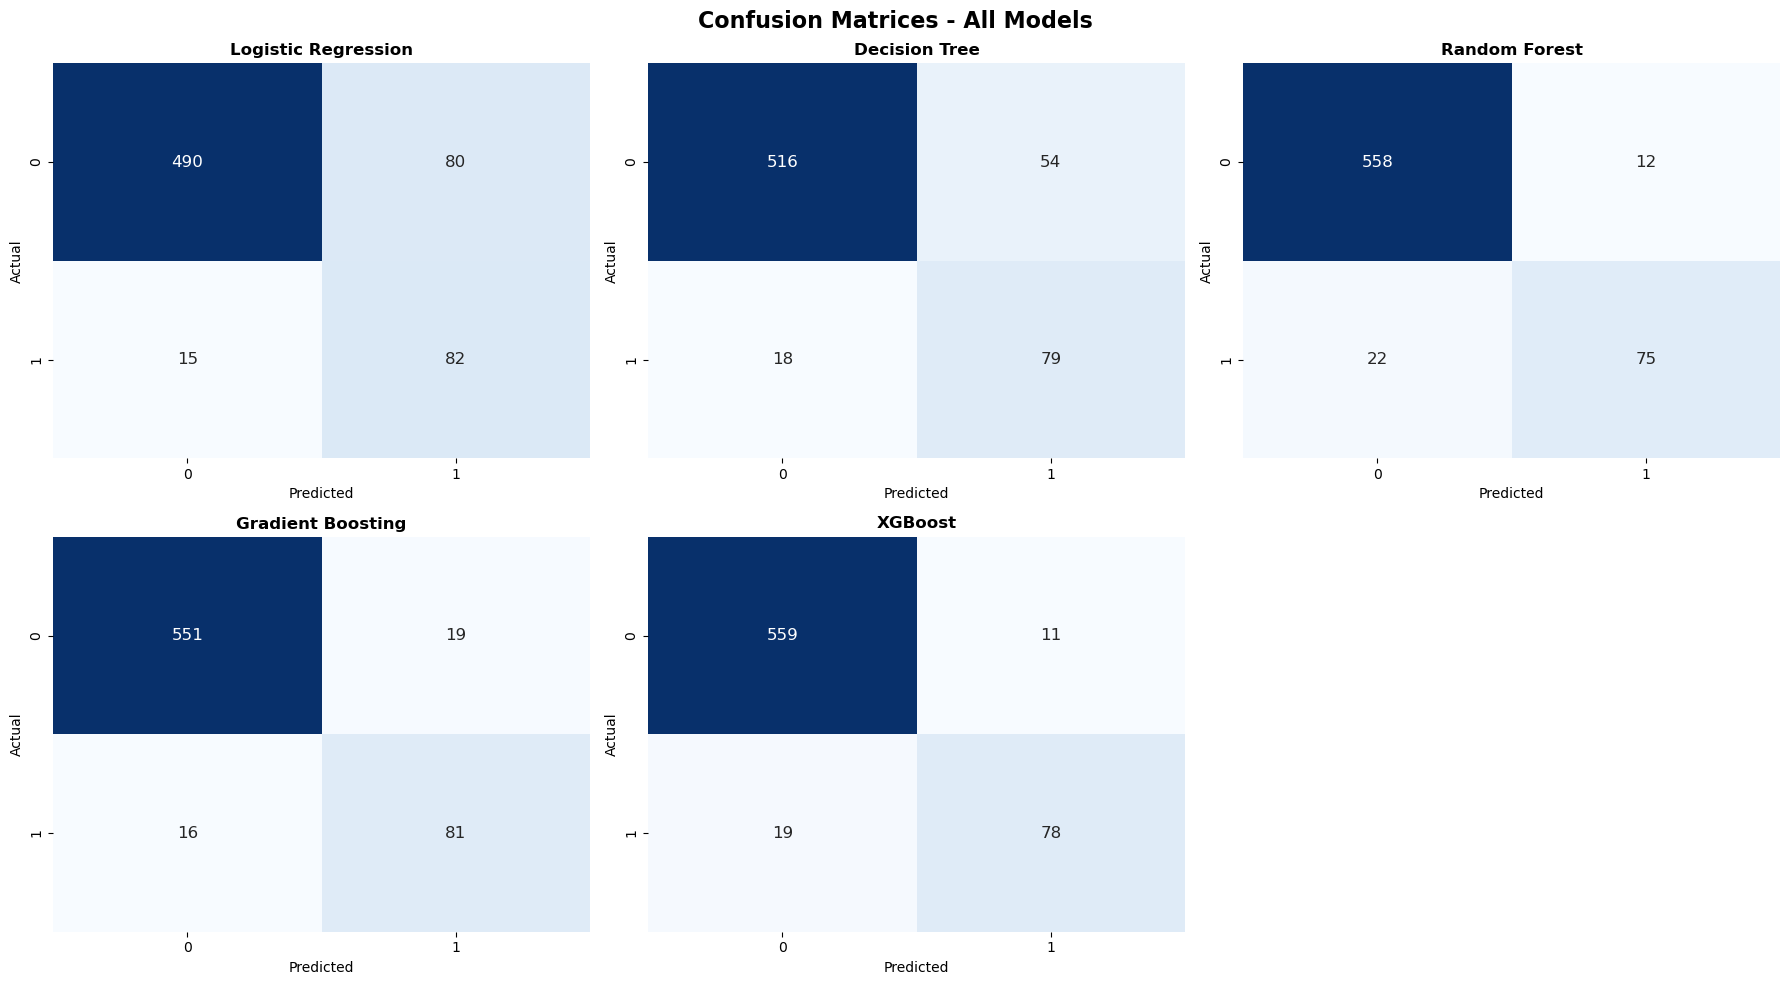

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, name in enumerate(models.keys()):
    cm = confusion_matrix(y_test, test_predictions[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, annot_kws={"size": 12})
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide the last subplot if odd number of models
if len(models) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('../visualizations/enhanced/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================
# ROC CURVES
# =============================================================

In [13]:
# plt.figure(figsize=(10, 8))

# colors = ['blue', 'red', 'green', 'orange', 'purple']
# for idx, (name, pred_dict) in enumerate(test_predictions.items()):
#     fpr, tpr, _ = roc_curve(y_test, pred_dict['y_prob'])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', 
#              linewidth=2, color=colors[idx % len(colors)])

# plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
# plt.legend(loc='lower right', fontsize=10)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.savefig('../visualizations/enhanced/roc_curves.png', dpi=300, bbox_inches='tight')
# plt.show()


# =============================================================
# OVERFITTING VISUALIZATION
# =============================================================

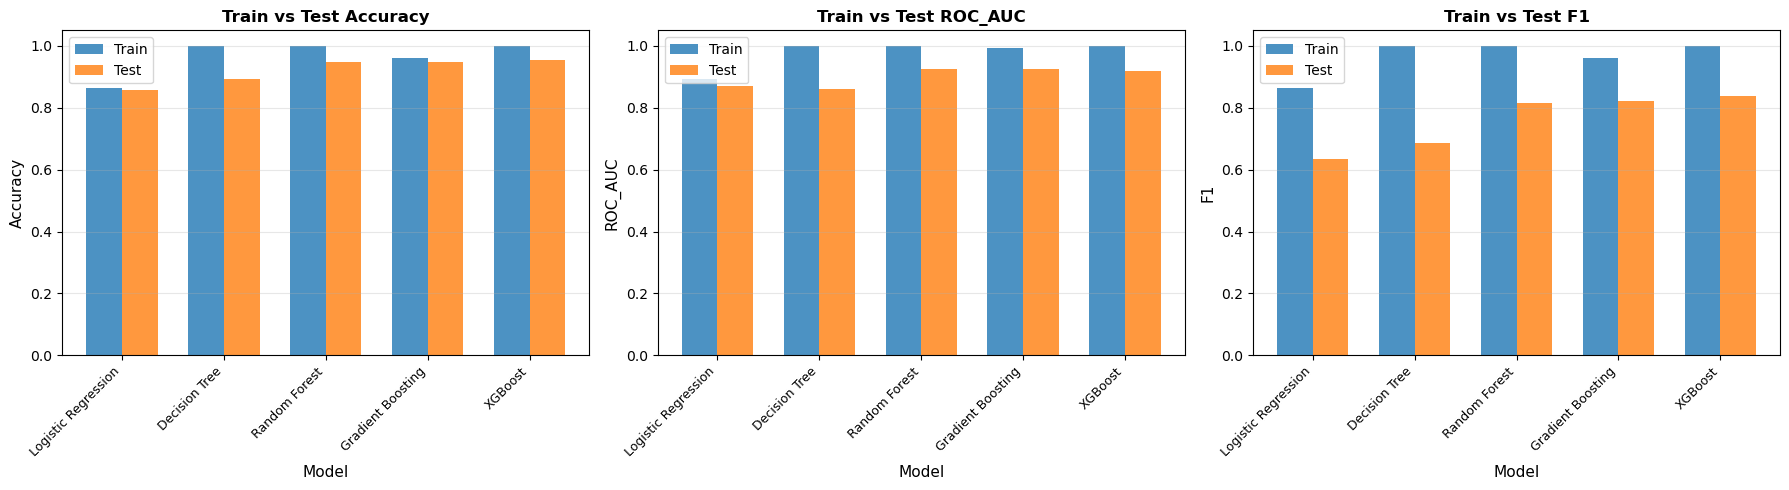

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'ROC_AUC', 'F1']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    x = np.arange(len(overfitting_df))
    width = 0.35
    
    train_col = f'Train_{metric}'
    test_col = f'Test_{metric}'
    
    ax.bar(x - width/2, overfitting_df[train_col], width, label='Train', alpha=0.8)
    ax.bar(x + width/2, overfitting_df[test_col], width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'Train vs Test {metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(overfitting_df['Model'], rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/enhanced/overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# =============================================================
# BEST MODEL SELECTION AND DETAILED REPORT
# =============================================================

In [15]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1-score :", f1_score(y_test, y_pred_xgb))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_xgb))

d:\Users\LENOVO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:18:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Evaluation:
Accuracy : 0.9550224887556222
Precision: 0.8764044943820225
Recall   : 0.8041237113402062
F1-score : 0.8387096774193549
ROC-AUC  : 0.9172363899439319


# =============================================================
# Hyperparameter Tuning
# =============================================================

In [16]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "roc_auc"

rf_param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
   "min_samples_split": stats.randint(2, 11),
    "min_samples_leaf": stats.randint(1, 5),
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=10,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False
)
rf_search.fit(X_train_resampled, y_train_resampled)
best_rf = rf_search.best_estimator_
print("Random Forest best params:", rf_search.best_params_)
print("Random Forest CV ROC-AUC:", rf_search.best_score_)

y_prob_rf_tuned = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf_tuned = best_rf.predict(X_test)
print("Random Forest (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_rf_tuned))



xgb_param_dist = {
    
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}


xgb_base = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=1,        
    n_estimators=50  
)

xgb_search = HalvingRandomSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_candidates=12,         
    factor=3,
    resource="n_estimators", 
    max_resources=100,      
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False,
)

try:
    xgb_search.fit(X_train_resampled, y_train_resampled)
    best_xgb = xgb_search.best_estimator_
    print("XGBoost best params:", xgb_search.best_params_)
    print("XGBoost CV ROC-AUC:", xgb_search.best_score_)
except KeyboardInterrupt:
    print("XGBoost search interrupted. Using best found so far (if any).")
    best_xgb = xgb_search.best_estimator_ if hasattr(xgb_search, "best_estimator_") else xgb_model

y_prob_xgb_tuned = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_tuned = best_xgb.predict(X_test)
print("XGBoost (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_xgb_tuned))



dt_param_grid = {
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

dt_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

dt_search.fit(X_train_resampled, y_train_resampled)
best_dt = dt_search.best_estimator_
print("Decision Tree best params:", dt_search.best_params_)
print("Decision Tree CV ROC-AUC:", dt_search.best_score_)

y_prob_dt_tuned = best_dt.predict_proba(X_test)[:, 1]
y_pred_dt_tuned = best_dt.predict(X_test)
print("Decision Tree (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_dt_tuned))

log_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear"]
}

log_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000, random_state=42),
    param_grid=log_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
log_search.fit(X_train_resampled, y_train_resampled)
best_log = log_search.best_estimator_
print("Logistic Regression best params:", log_search.best_params_)
print("Logistic Regression CV ROC-AUC:", log_search.best_score_)

y_prob_log_tuned = best_log.predict_proba(X_test)[:, 1]
y_pred_log_tuned = best_log.predict(X_test)
print("Logistic Regression (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_log_tuned))


tuned_comparison = pd.DataFrame([
    {"Model": "Random Forest (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_rf_tuned)},
    {"Model": "XGBoost (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_xgb_tuned)},
    {"Model": "Decision Tree (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_dt_tuned)},
    {"Model": "Logistic Regression (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_log_tuned)}
]).sort_values(by="ROC-AUC", ascending=False).round(3)

print("\\nTuned Model Performance (Test ROC-AUC):")
print(tuned_comparison)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest best params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
Random Forest CV ROC-AUC: 0.9905886426592797
Random Forest (tuned) ROC-AUC: 0.9239916802315065
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 5
min_resources_: 1
max_resources_: 100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 3
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 9
Fitting 3 folds for each of 2 candidates, totalling 6 fits


d:\Users\LENOVO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:18:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best params: {'subsample': 0.6, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'n_estimators': 9}
XGBoost CV ROC-AUC: 0.9634978070175438
XGBoost (tuned) ROC-AUC: 0.9224181587990594
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree best params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree CV ROC-AUC: 0.9437338411819022
Decision Tree (tuned) ROC-AUC: 0.9063754747693977
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Logistic Regression best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression CV ROC-AUC: 0.890911241920591
Logistic Regression (tuned) ROC-AUC: 0.8685476578043047
\nTuned Model Performance (Test ROC-AUC):
                         Model  ROC-AUC
0        Random Forest (tuned)    0.924
1              XGBoost (tuned)    0.922
2        Decision Tree (tuned)    0.906
3  Logistic Regression (tuned)    0.869


# =============================================================
# MODEL COMPARISON
# =============================================================

In [18]:
# best_model_name = comparison_df.iloc[0]['Model']
# best_model = trained_models[best_model_name]

# print(f"\nBEST MODEL: {best_model_name}\n")

# best_test_results = test_results_df[test_results_df['Model'] == best_model_name].iloc[0]
# best_overfitting = overfitting_df[overfitting_df['Model'] == best_model_name].iloc[0]

# print("\nTest Set Performance:")
# print(f"  Accuracy:  {best_test_results['Test_Accuracy']:.4f}")
# print(f"  Precision: {best_test_results['Test_Precision']:.4f}")
# print(f"  Recall:    {best_test_results['Test_Recall']:.4f}")
# print(f"  F1-Score:  {best_test_results['Test_F1']:.4f}")
# print(f"  ROC-AUC:   {best_test_results['Test_ROC_AUC']:.4f}")

# print("\nOverfitting Analysis:")
# print(f"  Train-Test Accuracy Gap: {best_overfitting['Accuracy_Gap']:.4f}")
# print(f"  Train-Test ROC-AUC Gap:  {best_overfitting['ROC_AUC_Gap']:.4f}")
# print(f"  Overfitting Risk:        {best_overfitting['Overfitting_Risk']}")

# print("\nDetailed Classification Report:")
# print(classification_report(y_test, test_predictions[best_model_name]['y_pred']))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(y_test, test_predictions[best_model_name]['y_pred'])
# print(cm)

In [19]:
# # --- Visualization of Model Performance ---

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10,6))
# sns.barplot(data=comparison.melt(id_vars="Model", var_name="Metric", value_name="Score"),
#             x="Model", y="Score", hue="Metric")
# plt.title("Model Performance Comparison", fontsize=16)
# plt.xticks(rotation=15)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# # Tuned model comparison visualization
# plt.figure(figsize=(8,4))
# sns.barplot(data=tuned_comparison, x="Model", y="ROC-AUC", palette="viridis")
# plt.title("Tuned Models ROC-AUC Comparison")
# plt.xticks(rotation=15)
# plt.tight_layout()
# plt.show()


In [ ]:
import os
import pandas as pd
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ✅ تحميل البيانات
df = pd.read_csv(r"C:\Users\hom\customer-churn-prediction-analysis\data\processed\cleaned_data.csv")

# ✅ اختيار الـ features النهائية
selected_features = [
    'State_VA', 'Total day charge', 'State_AZ', 'State_MD',
    'High_Customer_Service', 'State_RI', 'Total day minutes',
    'Total_Charge', 'State_IL', 'Total_Minutes', 'State_MT',
    'Customer service calls', 'International plan_Yes',
    'State_NJ', 'State_TX', 'State_HI', 'Voice mail plan_Yes'
]

target = 'Churn'

# ✅ فصل البيانات
X = df[selected_features]
y = df[target]

# ✅ تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ إنشاء وتدريب XGBoost
model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# ✅ التقييم
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob)
}

print("\n✅ XGBoost Model Performance on Selected Features:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# ✅ إنشاء المجلد قبل الحفظ
os.makedirs("models/trained_models", exist_ok=True)

# ✅ حفظ الموديل
joblib.dump(model, "models/trained_models/xgboost_selected_features.pkl")
print("\n💾 Model saved to: models/trained_models/xgboost_selected_features.pkl")



✅ XGBoost Model Performance on Selected Features:
Accuracy: 0.946
Precision: 0.918
Recall: 0.691
F1-score: 0.788
ROC-AUC: 0.935

💾 Model saved to: models/trained_models/xgboost_selected_features.pkl
